In [19]:
import polars as pl
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
meta = pl.read_parquet("/kaggle/input/uspto-boolean-search-optimization/patent_metadata.parquet")
meta.head(1)

publication_number,publication_date,filing_date,family_id,cpc_codes
str,datetime[μs],datetime[μs],f64,list[str]
"""US-1-A""",1836-07-13 00:00:00,null,2.060279e6,"[""B61C11/04""]"


In [10]:
counts = []
for cpc in meta["cpc_codes"]:
    counts.append(len(cpc))

In [12]:
counts = np.array(counts)
(counts == 0).mean()

0.0517561532373126

In [13]:
patent2cpcs = {}
for patent, cpcs in tqdm(zip(meta["publication_number"], meta["cpc_codes"])):
    patent2cpcs[patent] = cpcs

13307751it [00:35, 378223.12it/s]


In [14]:
nn_df = pl.read_csv("/kaggle/input/uspto-boolean-search-optimization/nearest_neighbors.csv")
nn_df.head(2)
metadata = pl.read_parquet(
    "/kaggle/input/uspto-boolean-search-optimization/patent_metadata.parquet"
)
metadata = metadata.with_columns(pl.col("publication_date").dt.year().alias("year"))
val_patents = set(metadata.filter(pl.col("year") >= 1975)["publication_number"].to_list())
print(len(val_patents))
nn_df = nn_df.filter(pl.col("publication_number").is_in(val_patents))
print(len(nn_df))

9457935
9457949


In [25]:
counts = []  # len(cpc) > 0 の個数(0<=count<=50)
for targets in tqdm(nn_df.sample(1_900_000).iter_rows()):
    count = 0
    targets = targets[1:]
    for target in targets:
        if target in patent2cpcs:
            count += len(patent2cpcs[target]) > 0
    counts.append(count)

1900000it [03:11, 9919.96it/s] 


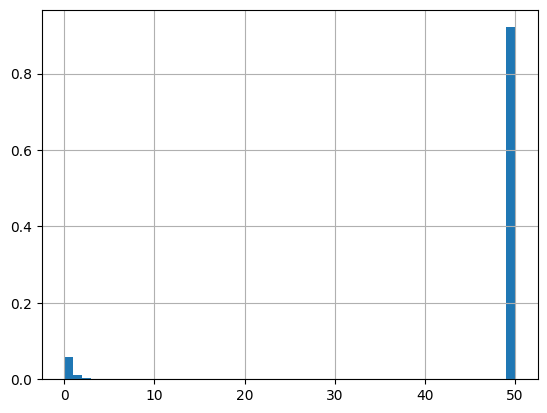

In [26]:
# 0<=count<=50 の分布
plt.hist(counts, bins=50, density=True)
plt.grid()
plt.show()